## Project Overview
This project focuses on extracting and analyzing mobile phone prices from Amazon Egypt to understand the pricing patterns, discounts, and market trends. Using Web Scraping with Selenium, we collected product details including names, prices, ratings, reviews, and product links. The data will be cleaned, structured, and explored through descriptive statistics and visualizations to identify price distributions, top discounted products, and brand comparisons.

## Objectives
1- Collect up-to-date product pricing data from Amazon Egypt (Mobiles category).

2- Analyze price distribution and identify market trends.

3- Detect the highest and lowest-priced products.

4- Identify products with the largest discounts.

5- Compare product ratings and review counts across different brands.


## Data Collection Process  

1. **Target Website**  
   - **Amazon Egypt** – Mobiles category (`https://www.amazon.eg`).  

2. **Approach**  
   - The data was collected using **Selenium WebDriver** to handle Amazon’s dynamic JavaScript-loaded content.  
   - The scraper navigates through multiple product listing pages and extracts relevant details.  

3. **Extracted Fields**  
   - **Product Name** – The name/title of the mobile phone.  
   - **Price** – The current listed price.  
   - **Rating** – The average star rating given by customers.  
   - **Review Count** – The total number of customer reviews.  
   - **Product Link** – Direct URL to the product page.  

4. **Pagination Handling**  
   - The scraper iterates through all available pages in the mobiles category until no more products are found.  

5. **Data Storage**  
   - All extracted data is stored in a **CSV file** (`amazon_eg_mobiles.csv`) with UTF-8 encoding for further processing and analysis.  

In [3]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
import pandas as pd
import time
import matplotlib.pyplot as plt

In [4]:
# Setup Chrome options
options = Options()
options.add_argument("--start-maximized")
options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36")

# Setup Chrome driver
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# Base URL (Amazon Egypt - Mobiles category)
base_url = "https://www.amazon.eg/s?i=electronics&rh=n%3A21832883031&s=popularity-rank&fs=true&language=en"

product_names = []
current_prices = []
ratings = []
review_counts = []

# Loop through first 3 pages
for page in range(1, 10):
    driver.get(f"{base_url}&page={page}")
    
    # Wait for products to load
    WebDriverWait(driver, 15).until(
        EC.presence_of_all_elements_located((By.CSS_SELECTOR, "div.s-main-slot div.s-result-item"))
    )
    
    # Scroll down slowly to load all products
    for i in range(3):
        driver.execute_script(f"window.scrollTo(0, document.body.scrollHeight*{(i+1)/3});")
        time.sleep(2)
    
    products = driver.find_elements(By.CSS_SELECTOR, "div.s-main-slot div.s-result-item")
    
    for product in products:
        try:
            name = product.find_element(By.CSS_SELECTOR, "h2 span").text
        except:
            name = None
        
        try:
            price = product.find_element(By.CSS_SELECTOR, "span.a-price-whole").text
        except:
            price = None
        
        try:
            rating_elem = product.find_element(By.CSS_SELECTOR, "i[data-cy='reviews-ratings-slot'] span.a-icon-alt")
            rating = rating_elem.get_attribute("textContent").strip().split()[0]
        except:
            rating = None
        
        try:
            review_count = product.find_element(By.CSS_SELECTOR, "span.a-size-base.s-underline-text").text
        except:
            review_count = None
        
        
        if name:  # Avoid empty slots
            product_names.append(name)
            current_prices.append(price)
            ratings.append(rating)
            review_counts.append(review_count)

driver.quit()

# Save to CSV
df = pd.DataFrame({
    "Product Name": product_names,
    "Price": current_prices,
    "Rating": ratings,
    "Review Count": review_counts
})

df.to_csv("amazon_eg_mobiles.csv", index=False, encoding="utf-8-sig")
print(f"Data saved to amazon_eg_mobiles.csv with {len(df)} products")


Data saved to amazon_eg_mobiles.csv with 243 products


## Data Cleaning

In [6]:
df.head()

,Product Name,Price,Rating,Review Count
0,"Xiaomi Redmi A3, 3GB RAM | 64GB ROM, 6.71 Inch...","3,888",3.6,372
1,Samsung Galaxy A06 Dual Sim 6GB RAM 128GB Stor...,"5,666",4.2,"1,895"
2,"Samsung Galaxy A05s, LTE, Android Smartphone, ...","5,999",4.1,"2,608"
3,"Samsung Galaxy A16 LTE, Android Smartphone, Du...","9,976",4.3,81
4,Apple iPhone 13 (128 GB) - Midnight with Face ...,"29,999",4.3,448


In [7]:
df.dtypes

Product Name    object
Price           object
Rating          object
Review Count    object
dtype: object

In [8]:
## change data types
df["Price"] = pd.to_numeric(df["Price"].str.replace(",", ""), errors="coerce")
df["Rating"] = pd.to_numeric(df["Rating"].str.replace(",", ""), errors="coerce")
df["Review Count"] = pd.to_numeric(df["Review Count"].str.replace(",", ""), errors="coerce")

In [9]:
df.describe()

,Price,Rating,Review Count
count,226.000000,192.000000,192.000000
mean,13384.991150,3.931771,703.453125
std,21520.952971,0.908817,2983.389277
min,49.000000,1.000000,1.000000
25%,363.250000,3.800000,7.000000
50%,3935.500000,4.100000,36.000000
75%,14899.000000,4.400000,180.750000
max,99950.000000,5.000000,29698.000000


In [10]:
# Remove any accessiories or non reliable prices
df = df[df['Price'] > 450]

In [11]:
df.isnull().sum()

Product Name     0
Price            0
Rating          25
Review Count    25
dtype: int64

In [12]:
# fill missing values 
df['Rating'] = df['Rating'].fillna(df['Rating'].mean())
df['Review Count'] = df['Review Count'].fillna(df['Review Count'].median())

In [13]:
# Remove mobile cases from list
df = df[~df['Product Name'].str.contains('Case', case=False, na=False)]

## EDA

### Relation between Price and Rating 

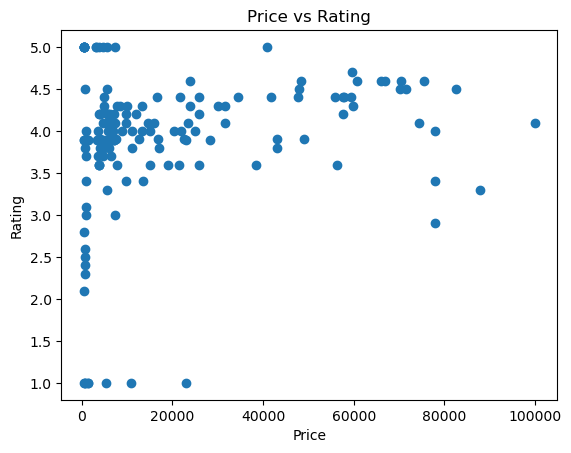

0.19976670510551348

In [16]:
plt.scatter(df['Price'], df['Rating'])
plt.xlabel('Price')
plt.ylabel('Rating')
plt.title('Price vs Rating')
plt.show()
df['Price'].corr(df['Rating'])

There is no Correlation between Price and Rating

### Top rated 5 mobiles

In [19]:
df[df['Review Count'] > 100].sort_values(by='Rating', ascending=False).head(5)

,Product Name,Price,Rating,Review Count
45,Apple iPhone 16 Pro Max (256 GB) - Black Titanium,75550.0,4.6,104.0
171,Apple iPhone 16e (128 GB) - White with Face ID...,48444.0,4.6,429.0
153,Apple iPad Pro 11-inch (M4): Ultra Retina XDR ...,66950.0,4.6,249.0
37,Apple iPhone 16 Pro (256 GB) - Desert Titanium...,70299.0,4.5,183.0
21,Apple iPhone 16 Pro Max (256 GB) - Black Titan...,82666.0,4.5,401.0


### Least rated 5 mobiles

In [21]:
df[df['Review Count'] > 100].sort_values(by='Rating').head(5)

,Product Name,Price,Rating,Review Count
0,"Xiaomi Redmi A3, 3GB RAM | 64GB ROM, 6.71 Inch...",3888.0,3.6,372.0
126,Nokia G21 Dual SIM 4GB Ram+128GB ROM (6.5 Inch...,5999.0,3.8,678.0
61,Itel A70 | 12GB (4+8) RAM + 128GB ROM| 13MP Du...,4050.0,3.8,241.0
8,"Samsung Galaxy A55 5G, Android Smartphone, Dua...",22500.0,3.9,1290.0
7,Xiaomi Redmi14C (8+256G) Midnight Black MediaT...,6444.0,3.9,132.0


### Price Category Analysis

In [23]:
def price_category(price):
    if price >= 40000:
        return 'Flagship'
    elif price < 40000 and price > 15000:
        return 'Mid-Range'
    else:
        return 'Low Budget'

In [24]:
df['Price Category'] = df['Price'].apply(price_category)
df['Price Category'].value_counts()

Price Category
Low Budget    109
Flagship       30
Mid-Range      25
Name: count, dtype: int64

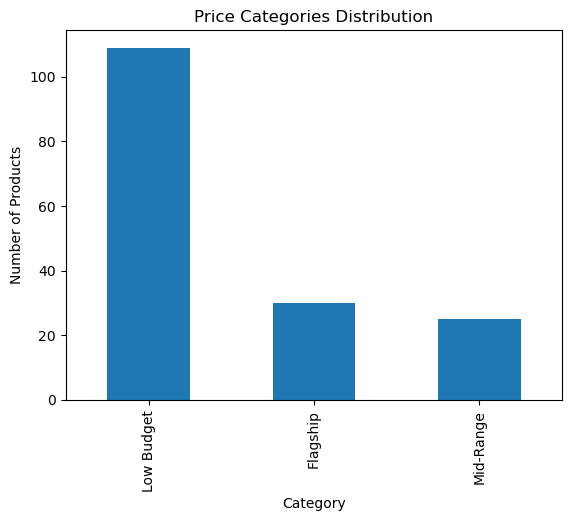

In [25]:
df['Price Category'].value_counts().plot(kind='bar')
plt.title("Price Categories Distribution")
plt.xlabel("Category")
plt.ylabel("Number of Products")
plt.show()

### Average Rating for Price categories

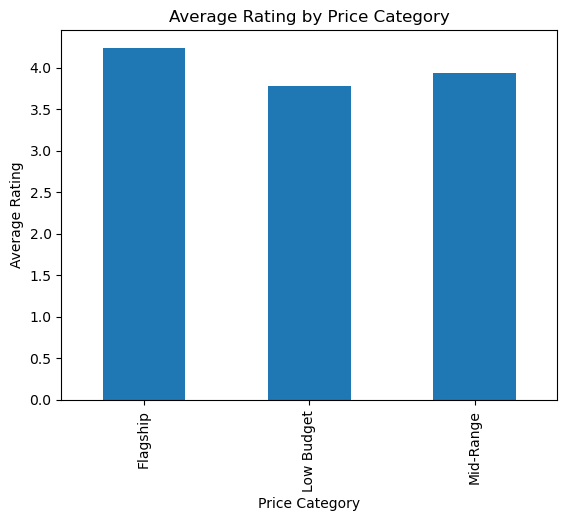

In [27]:
# Group by price category and calculate mean rating
average_rating = df.groupby('Price Category')['Rating'].mean()

average_rating.plot(kind='bar')
plt.title('Average Rating by Price Category')
plt.xlabel('Price Category')
plt.ylabel('Average Rating')
plt.show()

### Correlation between Rating and Review count

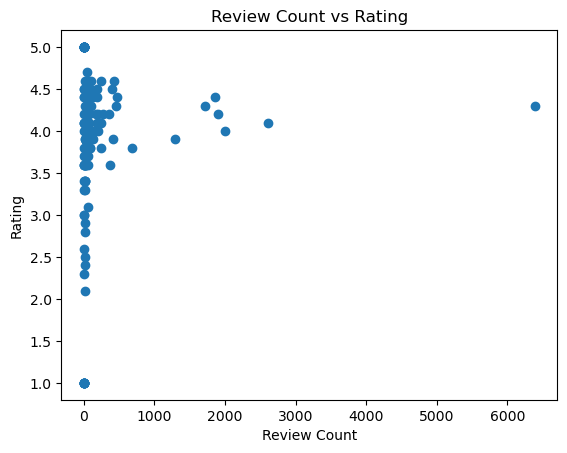

0.09447111845347955

In [29]:
plt.scatter(df['Review Count'], df['Rating'])
plt.xlabel('Review Count')
plt.ylabel('Rating')
plt.title('Review Count vs Rating')
plt.show()
df['Review Count'].corr(df['Rating'])

#### Very weak Correlation !

### Brands Analysis

In [107]:
# brands list
brands = ['Samsung', 'Apple', 'Xiaomi', 'Huawei', 'Realme', 'Oppo', 'Infinix', 'Vivo', 'Nokia', 'Honor','OnePlus', 'Motorola', 'Poco','Itel', 'Google Pixel', 'Redmi', 'Nothing', 'Ace', 'REDMAGIC']

def extract_brand(name):
    for brand in brands:
        if brand.lower() in name.lower():
            return brand
    return 'Other'

df = df[~df['Product Name'].str.contains('Selfie Stick', case=False, na=False)]

# Add Brand column 
df['Brand'] = df['Product Name'].apply(extract_brand)

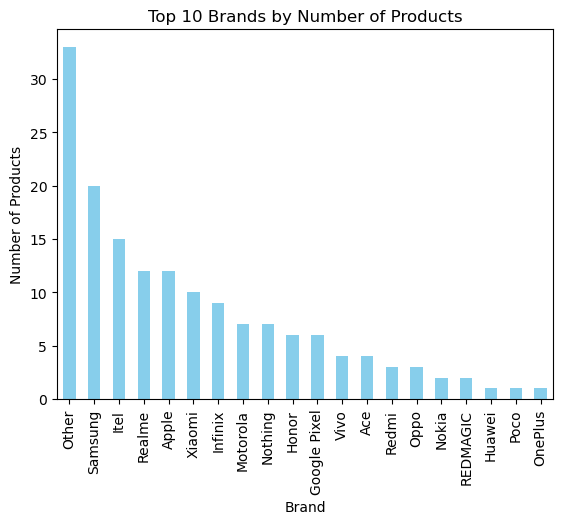

In [113]:
brand_counts = df['Brand'].value_counts()
# Top 10 Brands
brand_counts.plot(kind='bar', color='skyblue')
plt.title('Top 10 Brands by Number of Products')
plt.xlabel('Brand')
plt.ylabel('Number of Products')
plt.show()

In [127]:
brand_stats = df.groupby('Brand').agg({
    'Price': 'mean',
    'Rating': 'mean',
    'Product Name': 'count' 
}).rename(columns={'Product Name': 'Count'})
brand_stats['Price'] = brand_stats['Price'].round(0)
brand_stats['Rating'] = brand_stats['Rating'].round(1)
print(brand_stats.sort_values(by='Count', ascending=False).head(10))

                Price  Rating  Count
Brand                               
Other          1738.0     3.3     33
Samsung       33590.0     3.8     20
Itel           3978.0     4.1     15
Apple         63311.0     4.5     12
Realme         8888.0     3.5     12
Xiaomi        11744.0     4.0     10
Infinix        9827.0     4.0      9
Motorola      23364.0     3.8      7
Nothing       26170.0     4.2      7
Google Pixel  45617.0     4.4      6
